In [1]:
#!pip install -r requirements.txt

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import sys
print(sys.executable)
sys.path.append('/Users/janbannister/miniconda3/envs/jan_micrograd/lib/python3.12/site-packages')
from graphviz import Digraph

/Library/Frameworks/Python.framework/Versions/3.10/bin/python3.10


In [4]:
class Value:
    """ stores a single scalar value and its gradient """

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self.label = label
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op # the op that produced this node, for graphviz / debugging / etc

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * self.grad
            other.grad += 1.0 * self.grad
            print("\t + : Backward: 1.0 + " + str(self.grad) + " = " + str(self.grad))
            print("\t + : Backward: 1.0 + " + str(self.grad) + " = " + str(other.grad))
        self._backward = _backward
        
        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * self.grad
            other.grad += self.data * self.grad
            print("\t * : Backward: * -> " + str(self.grad))
            print("\t * : Backward: * -> " + str(other.grad))
        self._backward = _backward
        
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad += (1 - t**2) * self.grad
            print("\t tanh : Backward: tanh(x) : " + str(1 - t**2) +  " * " + str(self.grad))
        self._backward = _backward
        
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v) :
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            print(node)
            node._backward()
        
        
    def __repr__(self):
        return f"{self.label} \t= Value(op={self._op}, data={self.data}, grad={self.grad})"

In [5]:
def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
        
    def build(v):
        if v not in nodes: 
            nodes.add(v) 
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges 

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    
    nodes, edges = trace(root) 
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it 
        dot.node(name = uid, label = "{%s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record') 
        if n._op:
            # if this value is a result of some operation, create an op node for it 
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it 
            dot.edge(uid + n._op, uid)
            
    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
        
    return dot

In [6]:
# inputs xl,x2
x1 = Value(2.0,label='x1')
x2 = Value(8.0,label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label= 'w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*wl + x2*w2 + b
x1w1 = x1*w1; x1w1.label = '×1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1*w1 + x2*w2"

n = x1w1x2w2 + b;n.label = 'n'
o = n.tanh(); o.label = 'o'

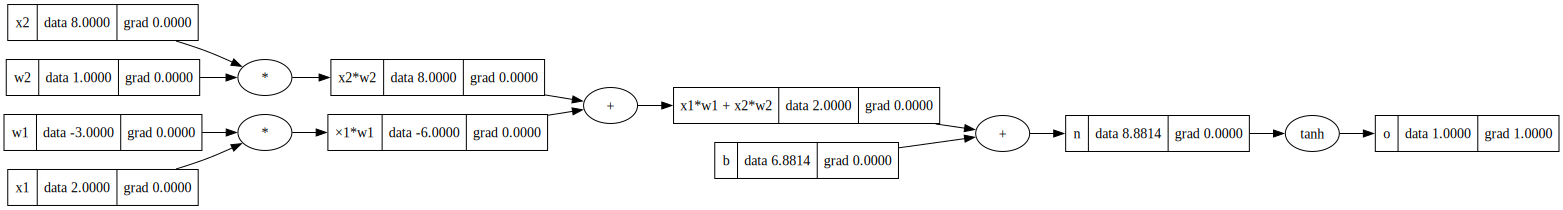

In [10]:
o.grad = 1.0
draw_dot(o)

In [8]:
o.backward()

o 	= Value(op=tanh, data=0.9999999613840338, grad=1.0)
n 	= Value(op=+, data=8.881373587019542, grad=0.0)
	 tanh : Backward: tanh(x) : 7.723193096165204e-08 * 0.0
b 	= Value(op=, data=6.881373587019543, grad=0.0)
x1*w1 + x2*w2 	= Value(op=+, data=2.0, grad=0.0)
	 + : Backward: 1.0 + 0.0 = 0.0
	 + : Backward: 1.0 + 0.0 = 0.0
×1*w1 	= Value(op=*, data=-6.0, grad=0.0)
	 + : Backward: 1.0 + 0.0 = 0.0
	 + : Backward: 1.0 + 0.0 = 0.0
x1 	= Value(op=, data=2.0, grad=0.0)
	 * : Backward: * -> 0.0
	 * : Backward: * -> 0.0
w1 	= Value(op=, data=-3.0, grad=0.0)
x2*w2 	= Value(op=*, data=8.0, grad=0.0)
x2 	= Value(op=, data=8.0, grad=0.0)
	 * : Backward: * -> 0.0
	 * : Backward: * -> 0.0
w2 	= Value(op=, data=1.0, grad=0.0)


In [9]:
o.grad = 1.0
#o.data = 0.51

topo = []
visited = set()

def build_topo(v) :
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)

print("Nodes:")
for node in reversed(topo):
    print(node)
    node._backward()
    print()
    
topo

Nodes:
o 	= Value(op=tanh, data=0.9999999613840338, grad=1.0)

n 	= Value(op=+, data=8.881373587019542, grad=0.0)
	 tanh : Backward: tanh(x) : 7.723193096165204e-08 * 0.0

b 	= Value(op=, data=6.881373587019543, grad=0.0)

x1*w1 + x2*w2 	= Value(op=+, data=2.0, grad=0.0)
	 + : Backward: 1.0 + 0.0 = 0.0
	 + : Backward: 1.0 + 0.0 = 0.0

×1*w1 	= Value(op=*, data=-6.0, grad=0.0)
	 + : Backward: 1.0 + 0.0 = 0.0
	 + : Backward: 1.0 + 0.0 = 0.0

x1 	= Value(op=, data=2.0, grad=0.0)
	 * : Backward: * -> 0.0
	 * : Backward: * -> 0.0

w1 	= Value(op=, data=-3.0, grad=0.0)

x2*w2 	= Value(op=*, data=8.0, grad=0.0)

x2 	= Value(op=, data=8.0, grad=0.0)
	 * : Backward: * -> 0.0
	 * : Backward: * -> 0.0

w2 	= Value(op=, data=1.0, grad=0.0)



[w2 	= Value(op=, data=1.0, grad=0.0),
 x2 	= Value(op=, data=8.0, grad=0.0),
 x2*w2 	= Value(op=*, data=8.0, grad=0.0),
 w1 	= Value(op=, data=-3.0, grad=0.0),
 x1 	= Value(op=, data=2.0, grad=0.0),
 ×1*w1 	= Value(op=*, data=-6.0, grad=0.0),
 x1*w1 + x2*w2 	= Value(op=+, data=2.0, grad=0.0),
 b 	= Value(op=, data=6.881373587019543, grad=0.0),
 n 	= Value(op=+, data=8.881373587019542, grad=0.0),
 o 	= Value(op=tanh, data=0.9999999613840338, grad=1.0)]